# **Training instance segmentation model with custom data using YOLOv11**

This notebook walks you through the process of training a custom YOLO v11 instance segmentation model using your own data.

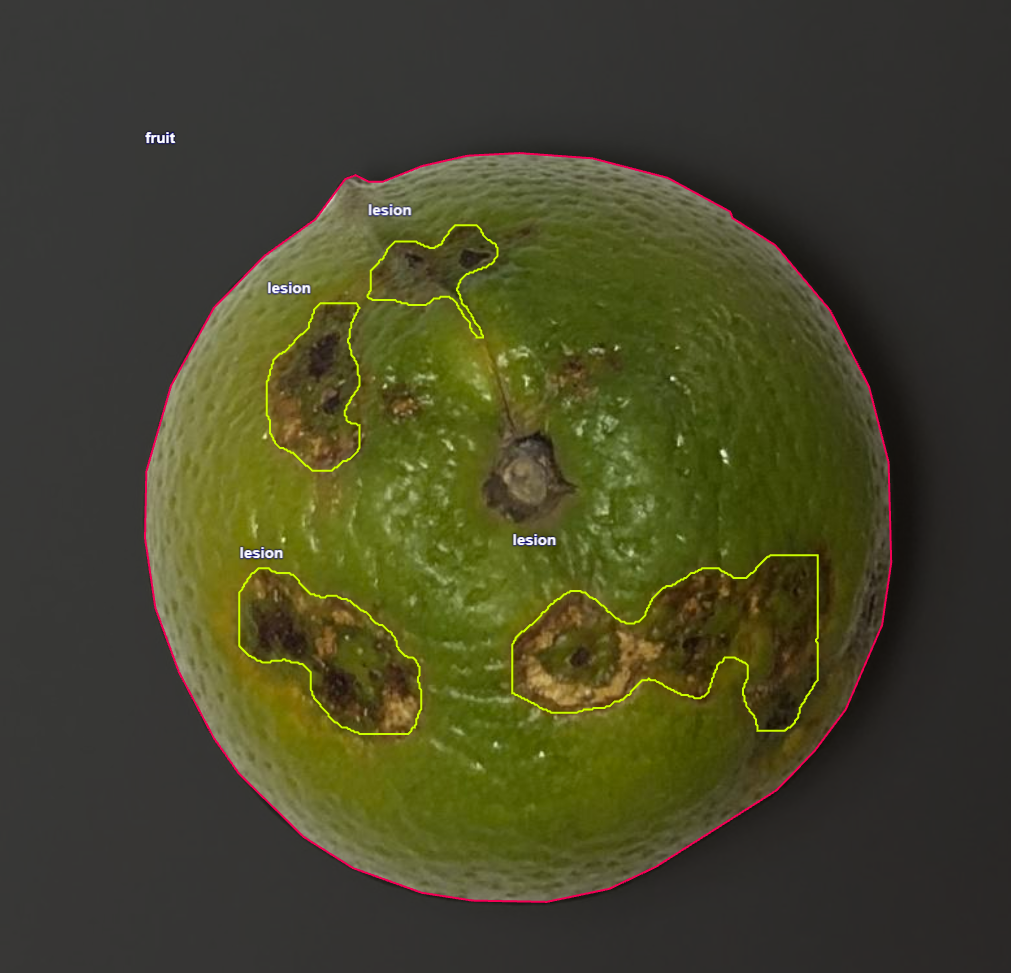

## *Learning objectives*

* Understand the difference between object detection and instance segmentation tasks.
* Set up and use a YOLOv11 (Ultralytics) segmentation model.
* Train a YOLO segmentation model using the custom dataset.
* Interpret training logs and metrics (loss curves, mAP, precision, recall).
* Perform inference using trained YOLO models.
* Extract and visualize segmentation outputs.

## Use GPU in Google Colab

Navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training process.

Check if we have we access to GPU, using `nvidia-smi` command

In [ ]:
!nvidia-smi

In [ ]:
# Clear GPU cache
import torch
torch.cuda.empty_cache()

## Install the required library: ultralytics

 All other libraries have been pre-installed on Colab.

In [ ]:
!pip install -U ultralytics

## Prepare the data

If you've already created annotations in COCO format—such as using makesense.ai—you can easily upload both your images and the JSON file to Roboflow to convert the annotations to other formats, like YOLO v11.

Alternatively, you can begin annotation directly within Roboflow by uploading your dataset and labeling it from scratch

Get big set

In [ ]:
!pip install -q gdown
# File ID (from your shared link)
file_id = "1znoekdhrQma8xysRdgvgUqLQGtV0YB6b"

# Construct the direct download URL
url = f"https://drive.google.com/uc?id={file_id}"

# Download the ZIP file and name it correctly
!gdown {url} -O citrus-disease-5.zip

# Unzip the contents into a folder called 'citrus-disease-5'
!unzip -q citrus-disease-5.zip -d citrus-disease-5

# Verify that extraction worked
!ls -R citrus-disease-5 | head -20

Get small set

In [ ]:
# First install gdown (if not already installed)
!pip install -q gdown

# File ID from your new link
file_id = "1yYnOxfidM3x4qorikOYNUjTgKzEe8kiR"

# Build the download URL
url = f"https://drive.google.com/uc?id={file_id}"

# Download it — name it appropriately (e.g. data.zip)
!gdown {url} -O data.zip

# Unzip into a folder (say “data”)
!unzip -q data.zip -d data

# Optionally list some files to check
!ls -R data | head -20


### Expore the dataset

Visualize original image and annotations

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob, os, random
from os.path import dirname as dir_up
%matplotlib inline

def visualize_yolo_segmentation_labels_with_plt(image_path, label_path):
    """
    Visualizes YOLO segmentation labels on an image using matplotlib.
    """

    # Define class mapping
    class_names = {0: "Fruit", 1: "Lesion"}

    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error: Could not read image at {image_path}")
        return

    # Convert the image from BGR (OpenCV) to RGB (Matplotlib)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img_rgb.shape

    # Define colors for different classes
    colors = [
        (255, 255, 0), (0, 255, 255), # (255, 0, 0), (0, 255, 0), (0, 0, 255),
        (128, 0, 128), (0, 128, 128), (128, 128, 0), (255, 165, 0), (255, 192, 203)
    ]

    # Read the label file
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) < 3:
            continue

        # FIX: Get the class ID from the first element of the list
        class_id = int(parts[0])

        # Get the normalized coordinates from the rest of the list
        coords = np.array(parts[1:], dtype=np.float32).reshape(-1, 2)

        # Convert normalized coordinates to absolute pixel coordinates
        coords[:, 0] *= w
        coords[:, 1] *= h
        polygon = coords.astype(np.int32)

        # Get a unique color for the mask
        color = colors[class_id % len(colors)]

        # Draw the filled polygon mask on the image with transparency
        overlay = img_rgb.copy()
        cv2.fillPoly(overlay, [polygon], color)
        alpha = 0.4  # Transparency factor
        img_rgb = cv2.addWeighted(overlay, alpha, img_rgb, 1 - alpha, 0)

        # Draw the outline of the polygon
        cv2.drawContours(img_rgb, [polygon], -1, color, 2)

        # Look up the class name and add text label at the top-left of the polygon
        label_text = class_names.get(class_id, f"Class {class_id}")

        if polygon.size > 0:
            x_min = np.min(polygon[:, 0])
            y_min = np.min(polygon[:, 1])
            cv2.putText(img_rgb, label_text, (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the result using Matplotlib
    plt.figure(figsize=(10, 8))
    plt.imshow(img_rgb)
    plt.title("YOLO Segmentation Ground Truth Visualization")
    plt.axis("off")  # Hide the axes for a cleaner view
    plt.show()


In [ ]:
# get all images path
images_path = glob.glob('/content/data/small_dataset/train/images/*.jpg')

# randomly get one image path
image_path = images_path[random.randint(0, len(images_path) - 1 )]

# get the corresponding annotation file path
two_up = dir_up(dir_up(image_path))
annotation_file = image_path.split("/")[-1].split(".jpg")[0] + ".txt"
annotation_path = os.path.join(two_up, "labels", annotation_file)

# use the above defined function
visualize_yolo_segmentation_labels_with_plt(image_path, annotation_path)

Edit the path in data.yaml

 change "../train/images" to "/content/data/small_dataset/train/images"

 change "../valid/images" to "/content/data/small_dataset/valid/images"

 change "../test/images" to "/content/data/small_dataset/test/images"




In [ ]:
!sed -i -e 's#\.\./train/images#/content/data/small_dataset/train/images#g; \
s#\.\./valid/images#/content/data/small_dataset/valid/images#g; \
s#\.\./test/images#/content/data/small_dataset/test/images#g' \
data/small_dataset/data.yaml

## Inference with Pre-trained YOLO Model on custom dataset

In [ ]:
from ultralytics import YOLO
model = YOLO("yolo11x-seg.pt") # load the model "yolo11n-seg.pt", "yolo11m-seg.pt"

In [ ]:
images_dir = "/content/data/small_dataset/test/images"
results = model.predict(source=images_dir, save=True) # use the model

In [ ]:
results[2].show()
results[3].show()

## model training with custom data

In [ ]:
# Load a model

from ultralytics import YOLO
model = YOLO("yolo11x-seg.pt")  # load a pretrained model (recommended for training)
# model=YOLO("PATH/TO/last.pt") # resume the previous training

# Train the model
train_results = model.train(
    data="/content/data/small_dataset/data.yaml",
    epochs=50, # number of training epochs
    patience=0, # early stopping patience
    imgsz=640,
    batch=8,
    resume=False, # True, if contuniue the interupted train, but model=YOLO("PATH/TO/last.pt")
    device=0 # device="cpu", or device=0 or device=0,1,2,3 for multiple GPU
    )

# details about configuration, hyper-parameters and metrics
# https://docs.ultralytics.com/usage/cfg/#why-use-mixed-precision-training-with-yolo-models
# https://docs.ultralytics.com/guides/yolo-performance-metrics/#class-wise-metrics

In [ ]:
# show the training results
from IPython.display import Image, display
Image(filename='/content/runs/segment/train/results.png', width=1000)

In [ ]:
# show one validation image
Image(filename='/content/runs/segment/train/val_batch0_pred.jpg', width=600)

## inference

Now, the model is trained, we can use it for inference.

In [ ]:
#List the saved models in 'runs' directory.
# Note that you may see multiple 'train' subdirectories numbered 1, 2, 3, etc, depending how many times you run the trainings

!ls /content/runs/segment/train/weights

In [ ]:
new_model = YOLO("/content/runs/segment/train/weights/best.pt")
results = new_model.predict(source=images_dir, save=True)

In [ ]:
from IPython.display import Image, display

for image_path in glob.glob('/content/runs/segment/predict2/*.jpg')[:2]:
      display(Image(filename=image_path, height=600))
      print("\n")


## Post analysis

In [ ]:
res = results[6]

**Extracting bounding polygons**

Use 'masks.xyn' for segments (normalized) and 'masks.xy' for segments (pixels)

In [ ]:
res.masks.xyn

**Extracting segmented masks**

In [ ]:
extracted_masks = res.masks.data

In [ ]:
extracted_masks.shape

Push the mask to cpu (from GPU) and convert to numpy array for easy plotting.

In [ ]:
masks_array = extracted_masks.cpu().numpy()

In [ ]:
masks_array[25]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(masks_array[25])

**Extracting labels for each class**

In [ ]:
class_names = res.names.values()
class_names

In [ ]:
# Extract the bounding boxes data, which contain x_center, y_center, width, hight, confidence, class_id
detected_boxes =  res.boxes.data

# Extract class IDs from the detected boxes
class_labels = detected_boxes[:, -1].int().tolist()

# Initialize a dictionary to hold masks by class
masks_by_class = {name: [] for name in  res.names.values()}

# Iterate through the masks and class labels
for mask, class_id in zip(extracted_masks, class_labels):
    class_name =  res.names[class_id]  # Map class ID to class name
    masks_by_class[class_name].append(mask.cpu().numpy())

In [ ]:
for class_name, masks in masks_by_class.items():
    print(f"Class Name: {class_name}, Number of Masks: {len(masks)}")

**Extracting masks for a specific class**

In [ ]:
orange_masks = masks_by_class['fruit']
lesion_masks = masks_by_class['lesion']

In [ ]:
# Extract the original image
orig_img = res.orig_img

In [ ]:
orig_img.shape

display masks on the original image

In [ ]:
# Display the original image
plt.imshow(orig_img, cmap='gray')

# Overlay the mask with some transparency
plt.imshow(orange_masks[0], cmap='magma', alpha=0.3)
plt.imshow(lesion_masks[0], cmap='viridis', alpha=0.3)
plt.axis('off') # Turn off axis labels
plt.show()

**Calculating region properties for all objects and saving to a csv file.**

In [ ]:
import pandas as pd
from skimage.measure import regionprops

# Initialize a list to store the properties
props_list = []

# Iterate through all classes
for class_name, masks in masks_by_class.items():
    # Iterate through the masks for this class
    for mask in masks:
        # Convert the mask to an integer type if it's not already
        mask = mask.astype(int)

        # Apply regionprops to the mask
        props = regionprops(mask)

        # Extract the properties you want (e.g., area, perimeter, centroid) and add them to the list
        for prop in props:
            area = prop.area
            perimeter = prop.perimeter
            # Add other properties as needed

            # Append the properties and class name to the list
            props_list.append({'Class Name': class_name, 'Area': area, 'Perimeter': perimeter})

# Convert the list of dictionaries to a DataFrame
props_df = pd.DataFrame(props_list)

# Now props_df contains the properties and class names for all regions

# Save the DataFrame to a CSV file
props_df.to_csv('object_properties.csv', index=False)

In [ ]:
props_df

**Plotting results**

In [ ]:
import seaborn as sns

In [ ]:
# Create the swarm plot with Seaborn
sns.swarmplot(x='Class Name', y='Area', data=props_df)

# Add labels and a title
plt.xlabel('Class Name')
plt.ylabel('Area')
plt.title('Area of Objects for Each Class')

# Rotate the x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
# Create the swarm plot with Seaborn
sns.swarmplot(x='Class Name', y='Perimeter', data=props_df)

# Add labels and a title
plt.xlabel('Class Name')
plt.ylabel('Perimeter')
plt.title('Perimeter of Objects for Each Class')

# Rotate the x-axis labels for better visibility if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()